In [53]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from scipy.stats import ttest_rel

In [2]:
def add_label_to_df(df, path_to_labels):
    """Add label description to the input dataframe."""
    if Path(path_to_labels).is_dir():
        series_to_labels_mapping = {}
        for path in Path(path_to_labels).glob('*.json'):
            with open(path, 'r') as file:
                labels = json.load(file)
                series_to_labels_mapping.update({
                    f"{path.stem}": labels
                })
    elif Path(path_to_labels).is_file():
        with open(path_to_labels, 'r') as file:
            series_to_labels_mapping = json.load(file)
    else:
        raise ValueError(f"path_to_labels ''{path_to_labels}' must be file or directory'")
    labels_mapping_list = [
        {
            "series_uuid": series,
            "foreground_label": int(value),
            "label_description": ','.join([value_.lower().strip() for value_ in label.split(',')])
        }
        for series, mapping in series_to_labels_mapping.items()
        for value, label in mapping.items()
    ]
    labels_mapping_df = pd.DataFrame(labels_mapping_list)
    new_df = df.copy()
    new_df["series_uuid"] = new_df["ct_fname"].apply(lambda x: x.split('.nii.gz')[0])
    merged_df = new_df.merge(labels_mapping_df, on=["series_uuid", "foreground_label"], how='left')
    return merged_df

In [3]:
def concatenate_iteration_dfs(iteration_dfs):
    """Return concatenated dataframes with the column 'iteration'
    added.

    Parameters
    ----------
    iteration_dfs : list
        Each item is a dictionary with the following keys:
            'path': path to the performance JSON file.
            'iteration': integer indicating the iteration.
    """
    dfs = []
    for item in iteration_dfs:
        with open(item['path'], 'r') as file:
            df = pd.DataFrame(json.load(file)['bboxes'])
        df['iteration'] = item['iteration']
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True).sort_values(by='iteration')

In [109]:
def run_paired_t_test(performance_df, iteration_a = 0, iteration_b = 1):
    "Test the difference between the means of both iterations (iteration_b - iteration_a)."
    performance_df_subset = performance_df[(performance_df['iteration'] == iteration_a) | (performance_df['iteration'] == iteration_b)].copy()
    duplicated = performance_df_subset['bbox_original_fname'].duplicated(keep=False)
    filtered = performance_df_subset[duplicated]
    filtered_a = filtered[filtered['iteration'] == iteration_a].copy()
    filtered_b = filtered[filtered['iteration'] == iteration_b].copy()
    filtered_a.sort_values(by='bbox_original_fname', inplace=True)
    filtered_b.sort_values(by='bbox_original_fname', inplace=True)
    new_df = {
        f"index_iteration_{iteration_a}": filtered_a.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_a}": filtered_a['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_a}": filtered_a['dice_score'].to_list(),
        f"index_iteration_{iteration_b}": filtered_b.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_b}": filtered_b['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_b}": filtered_b['dice_score'].to_list()
    }
    new_df = pd.DataFrame(new_df)
    new_df['paired_sample'] = new_df.apply(
        lambda row: row[f"bbox_original_fname_iteration_{iteration_a}"] == row[f"bbox_original_fname_iteration_{iteration_b}"],
        axis=1
    )
    new_df['difference'] = new_df[f"dice_score_iteration_{iteration_a}"] - new_df[f"dice_score_iteration_{iteration_b}"]
    ttest_result = ttest_rel(
        new_df[f"dice_score_iteration_{iteration_b}"],
        new_df[f"dice_score_iteration_{iteration_a}"]
    )
    return ttest_result, new_df

# Evolución del desempeño de MedSAM mediante estrategia HITL
- El desempeño se mide sobre un conjunto de **13 volúmenes CT** (6 anotados por GP y 7 anotados por MF), correspondientes a **5 pacientes**:
    - 2208: cáncer de recto (3 estudios, 3 series anotadas)
    - 10980: cáncer de vejiga (3 estudios, 3 series anotadas)
    - 10976: cáncer de vesícula biliar (3 estudios, 3 series anotadas)
    - 10979: cáncer gástrico (2 estudios, 2 series anotadas)
    - 10978: cáncer de colon (1 estudio, 2 series anotadas)
- La iteración 0 corresponde a la evaluación del modelo MedSAM sin ajuste con datos locales.
- La iteración 1 corresponde a la evaluación del modelo MedSAM ajustado sobre un conjunto de **10 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **4 pacientes**:
    - 1: cáncer gástrico (1 estudio, 1 serie anotada)
    - 2: cáncer gástrico (4 estudios, 6 series anotadas)
    - 3: cáncer de mama (2 estudios, 2 series anotadas)
    - 14: cáncer de pulmón (1 estudio, 1 serie anotada)

In [4]:
iteration_dfs = [
    {
        'path': Path.cwd() / "resources" / "performance_iteration_0.json",
        'iteration': 0
    },
    {
        'path': Path.cwd() / "resources" / "performance_iteration_1.json",
        'iteration': 1
    },
]
path_to_labels = Path.cwd() / "resources" / "labels"
performance_df = concatenate_iteration_dfs(iteration_dfs)
performance_df = add_label_to_df(performance_df, path_to_labels)

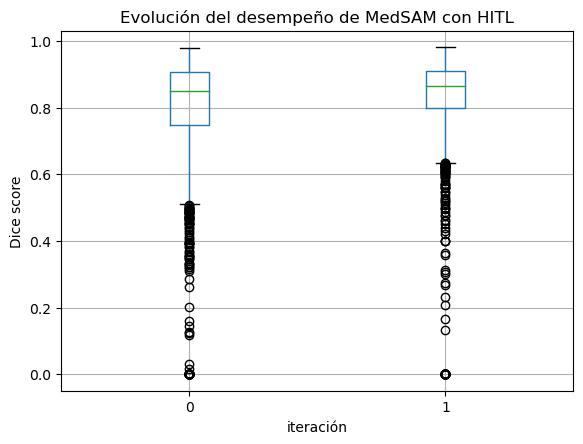

dice_score                                                         \
               count      mean       std  min       25%       50%       75%   
iteration                                                                     
0             2469.0  0.790306  0.190382  0.0  0.746667  0.848235  0.905028   
1             2468.0  0.824151  0.166161  0.0  0.800000  0.865846  0.910309   

                     
                max  
iteration            
0          0.978966  
1          0.981192

In [5]:
# Boxplot of Dice score for each iteration (all lesions)
performance_df.boxplot(column='dice_score', by='iteration')
plt.suptitle('')
plt.title('Evolución del desempeño de MedSAM con HITL')
plt.xlabel('iteración')
plt.ylabel('Dice score')
plt.show()
display(performance_df[['dice_score', 'iteration']].groupby('iteration').describe())

In [6]:
iterations = performance_df['iteration'].unique()
iterations_count = len(iterations)
lesion_types_count = len(performance_df['label_description'].unique())
print(f"# iteraciones: {iterations_count}")
print(f"# tipos de lesión: {lesion_types_count}")

# iteraciones: 2
# tipos de lesión: 7


In [14]:
iterations


[0, 1]

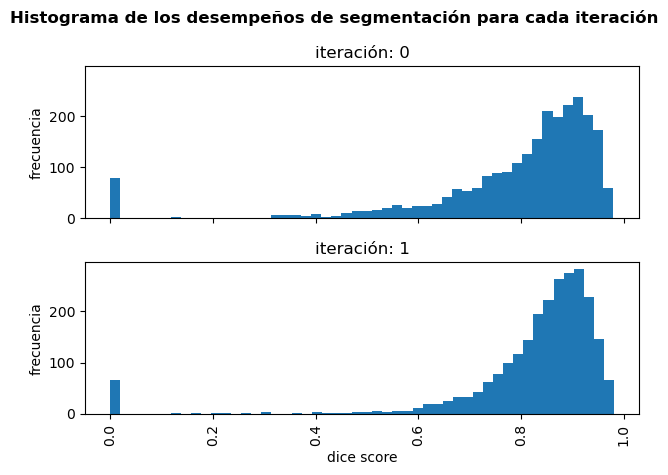

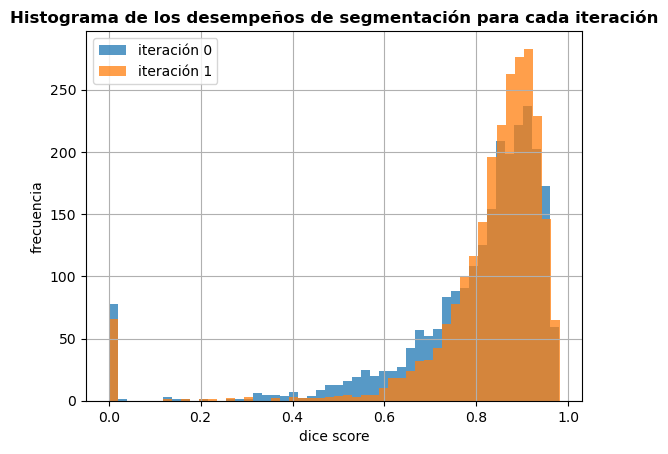

In [52]:
# Histogram of Dice score for each iteration (all lesions)
fig, ax = plt.subplots(nrows=iterations_count, ncols=1, sharex=True, sharey=True)
performance_df.hist(
    column='dice_score',
    by='iteration',
    bins=50,
    ax=ax
)
fig.suptitle('Histograma de los desempeños de segmentación para cada iteración', fontweight='bold')
for idx in range(iterations_count):
    ax[idx].set_ylabel('frecuencia')
    ax[idx].set_title(f"iteración: {iterations[idx]}")
ax[-1].set_xlabel('dice score')
plt.tight_layout()
plt.show()
# Overlapped histograms
fig, ax = plt.subplots(nrows=1, ncols=1)
cmap = plt.get_cmap('tab10')
for it in iterations:
    performance_df[performance_df['iteration'] == it].hist(
        column='dice_score',
        bins=50,
        ax=ax,
        color=cmap(it),
        alpha=0.75,
        label=f"iteración {it}"
    )

ax.legend()
ax.set_title('Histograma de los desempeños de segmentación para cada iteración', fontweight='bold')
ax.set_xlabel('dice score')
ax.set_ylabel('frecuencia')
plt.show()

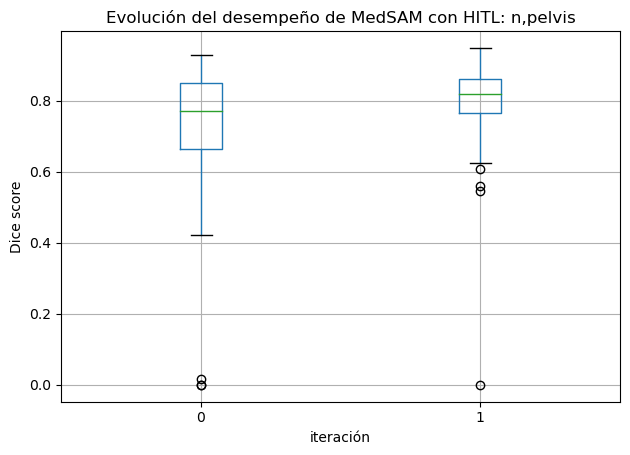

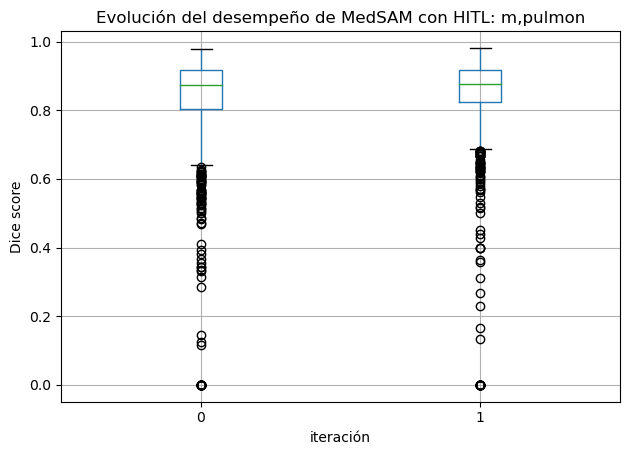

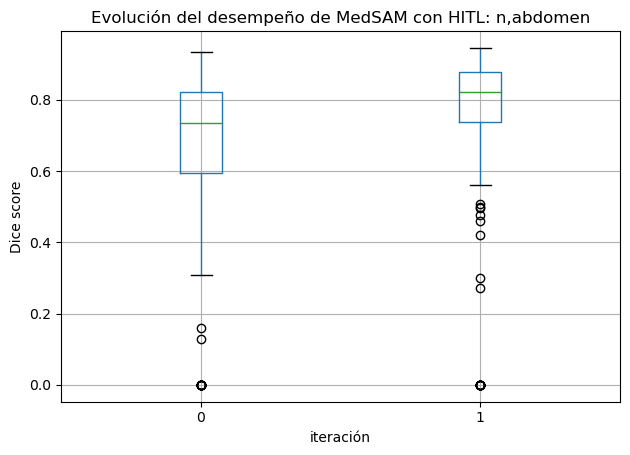

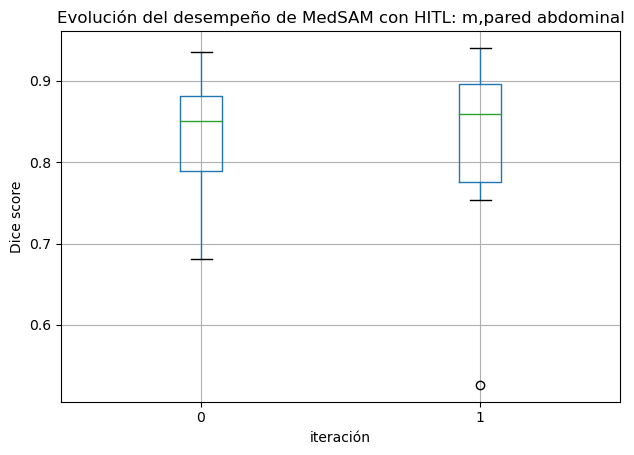

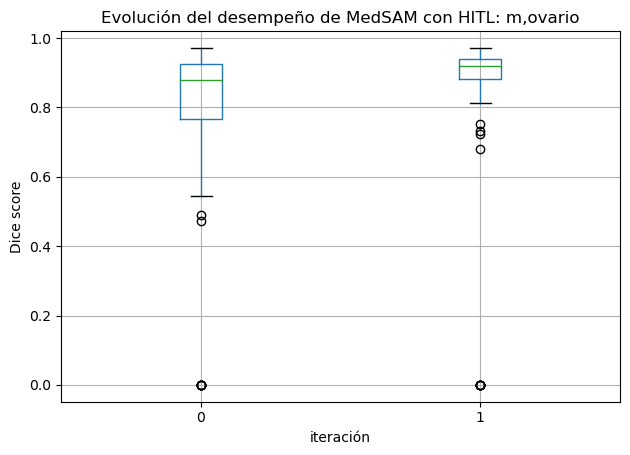

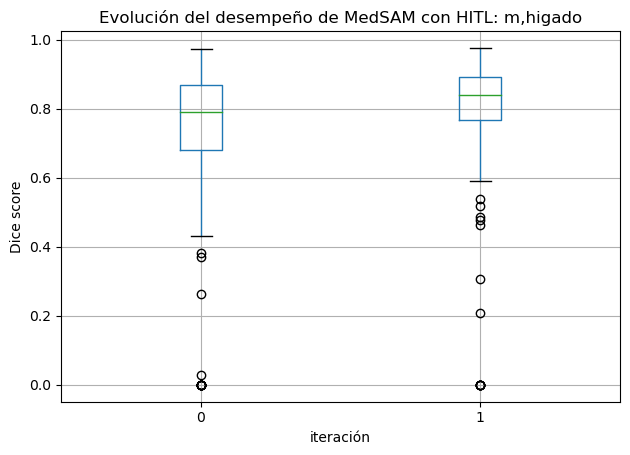

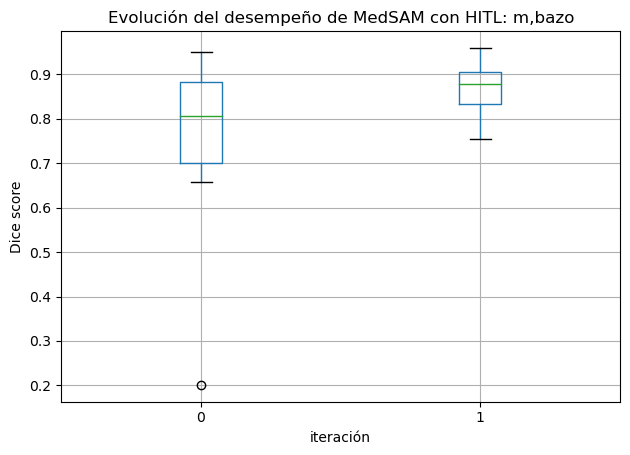

In [8]:
# Boxplot of Dice score for each iteration, dissagregated by lesion type
unique_lesions = list(performance_df['label_description'].unique())
for lesion in unique_lesions:
    performance_df[performance_df['label_description'] == lesion].boxplot(column='dice_score', by='iteration')
    plt.suptitle('')
    plt.title(f'Evolución del desempeño de MedSAM con HITL: {lesion}')
    plt.xlabel('iteración')
    plt.ylabel('Dice score')
    plt.tight_layout()
    plt.show()

In [9]:
display(performance_df.groupby(['label_description', 'iteration'])['dice_score'].describe())

count      mean       std       min       25%  \
label_description iteration                                                   
m,bazo            0            18.0  0.768426  0.169853  0.201117  0.699643   
                  1            18.0  0.866444  0.053129  0.755102  0.832288   
m,higado          0           224.0  0.733479  0.221123  0.000000  0.679675   
                  1           224.0  0.795796  0.181394  0.000000  0.766439   
m,ovario          0            89.0  0.787322  0.255064  0.000000  0.767013   
                  1            89.0  0.838932  0.252071  0.000000  0.881011   
m,pared abdominal 0            20.0  0.837178  0.069270  0.680556  0.788967   
                  1            20.0  0.832210  0.095049  0.526316  0.775966   
m,pulmon          0          1599.0  0.829590  0.164820  0.000000  0.804955   
                  1          1599.0  0.841755  0.153730  0.000000  0.824904   
n,abdomen         0           388.0  0.678886  0.208587  0.000000  0.594207   
                  1           388.0  0.769964  0.188531  0.000000  0.738416   
n,pelvis          0           131.0  0.735863  0.165140  0.000000  0.663830   
                  1           130.0  0.800987  0.108039  0.000000  0.764809   

                                  50%       75%       max  
label_description iteration                                
m,bazo            0          0.806712  0.883641  0.950033  
                  1          0.877899  0.906088  0.958797  
m,higado          0          0.789370  0.867119  0.973047  
                  1          0.839396  0.892452  0.975158  
m,ovario          0          0.879831  0.926251  0.970973  
                  1          0.920941  0.940691  0.970153  
m,pared abdominal 0          0.850516  0.881024  0.934911  
                  1          0.859708  0.896269  0.940032  
m,pulmon          0          0.875000  0.916842  0.978966  
                  1          0.877358  0.917219  0.981192  
n,abdomen         0          0.733952  0.822500  0.935519  
                  1          0.823183  0.877746  0.945255  
n,pelvis          0          0.770318  0.850480  0.927711  
                  1          0.818777  0.861630  0.947424

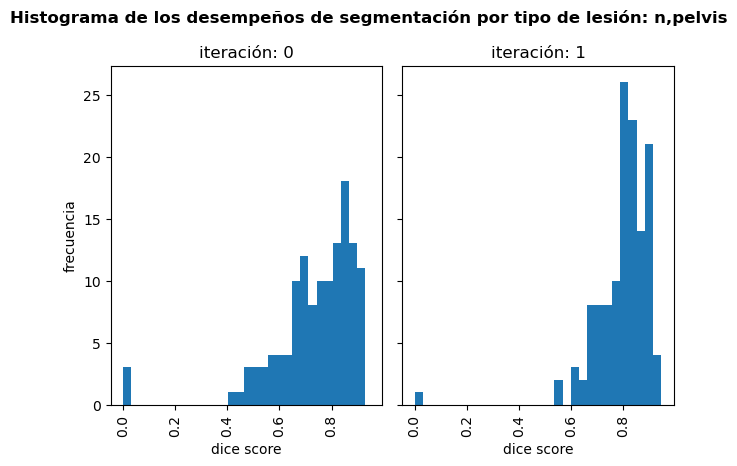

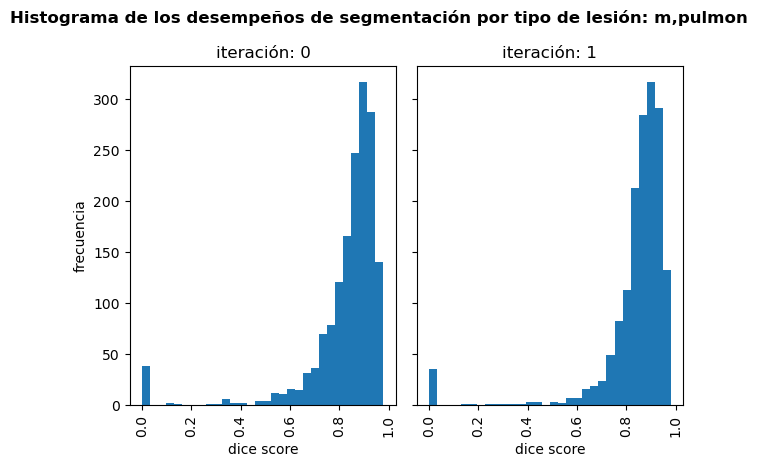

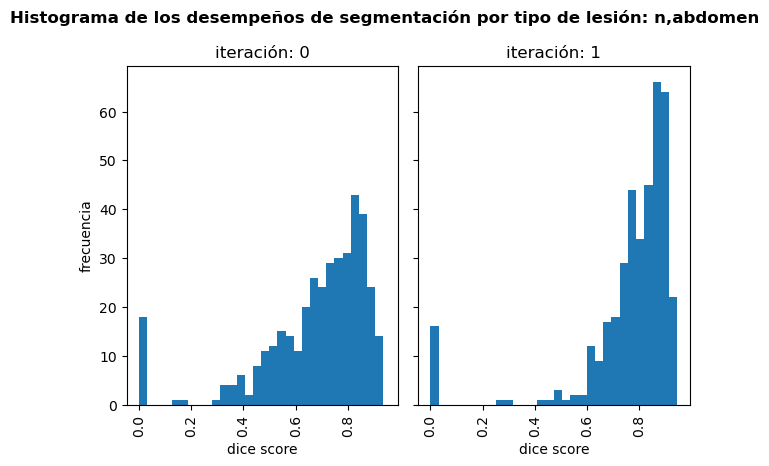

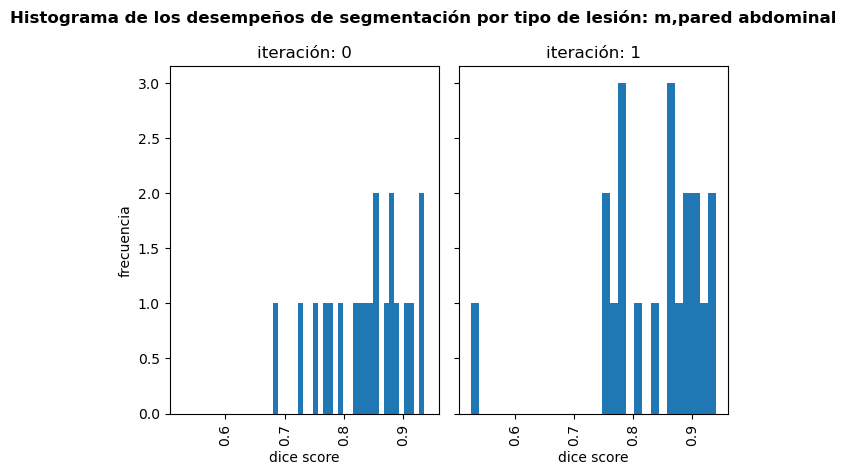

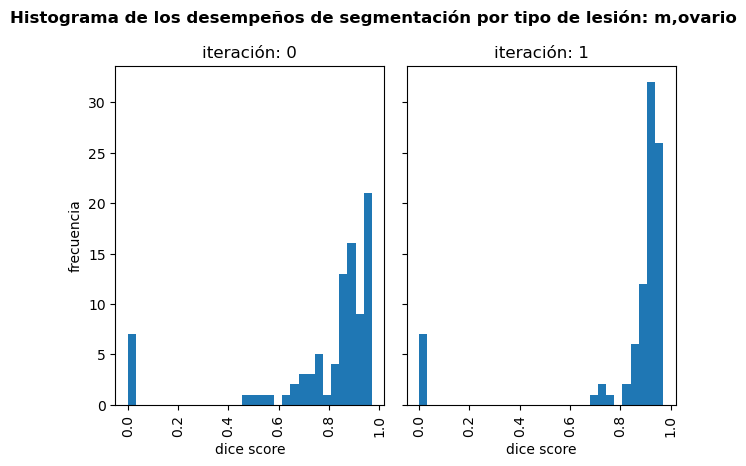

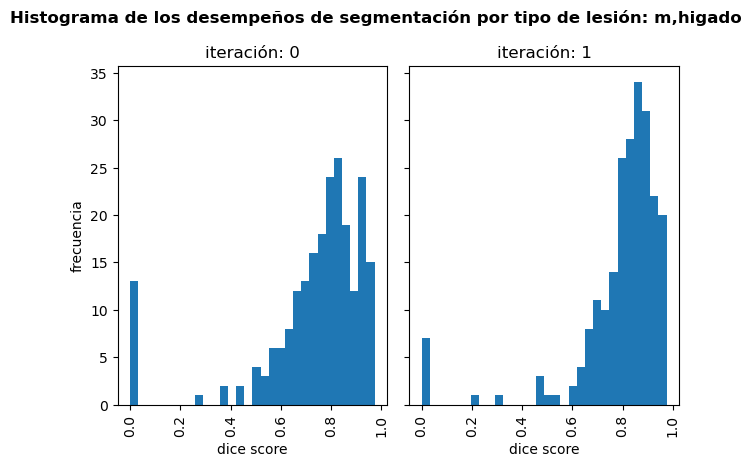

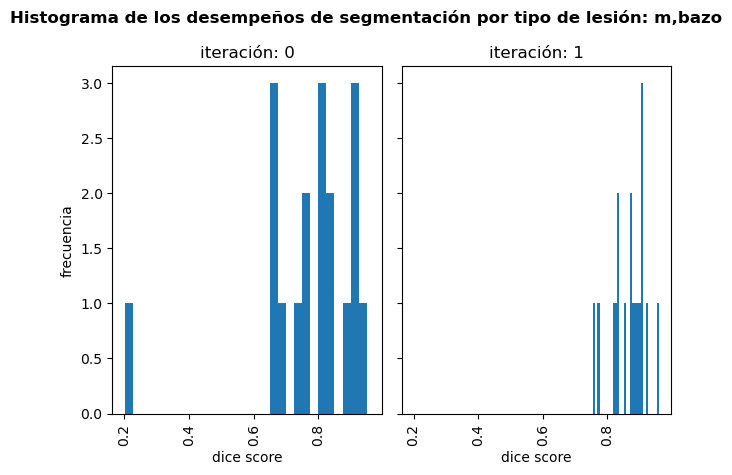

In [10]:
# Histogram of Dice score for each iteration, dissagregated by lesion type
for lesion in unique_lesions:
    fig, ax = plt.subplots(nrows=1, ncols=iterations_count, sharex=True, sharey=True)
    fig.suptitle(
        f'Histograma de los desempeños de segmentación por tipo de lesión: {lesion}',
        fontweight='bold'
    )
    performance_df[performance_df['label_description'] == lesion].hist(
        column='dice_score',
        by='iteration',
        bins=30,
        ax=ax
    )
    ax[0].set_ylabel('frecuencia')
    for idx in range(iterations_count):
        ax[idx].set_xlabel('dice score')
        ax[idx].set_title(f"iteración: {iterations[idx]}")
    plt.tight_layout()
    plt.show()

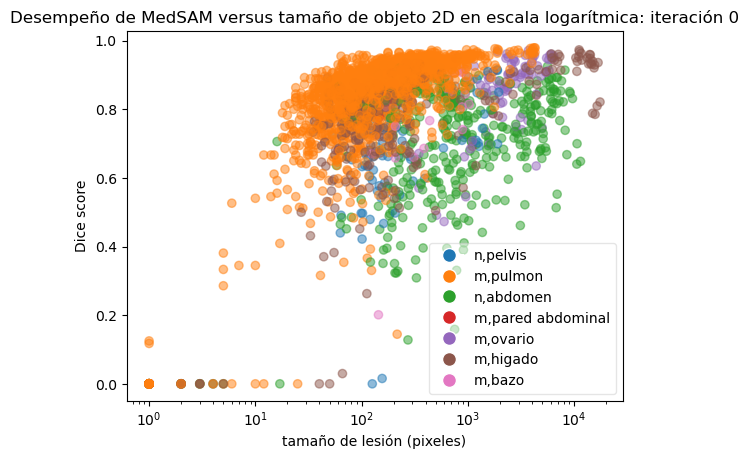

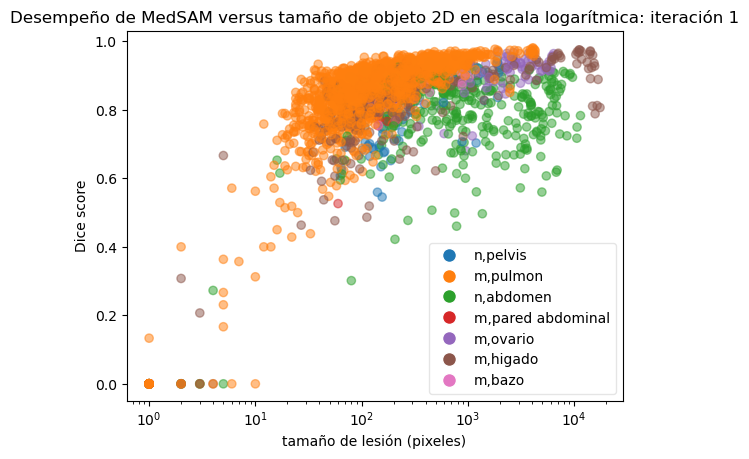

In [47]:
# Scatterplot of Dice versus object size, one plot for each iteration
iterations = list(performance_df['iteration'].unique())
# Add a color for each unique label description
cmap = plt.get_cmap('tab10')
color_mapping = {
    label: cmap(idx)
    for idx, label in enumerate(unique_lesions)
}
for iteration in iterations:
    _, ax = plt.subplots()
    filtered_df = performance_df[performance_df['iteration'] == iteration]
    colors = filtered_df["label_description"].map(color_mapping)
    ax.scatter(
        filtered_df['annotated_pixels'],
        filtered_df['dice_score'],
        c=colors.to_list(),
        label=filtered_df["label_description"],
        alpha=0.5
    )
    ax.set_xscale('log')
    ax.set_title(f'Desempeño de MedSAM versus tamaño de objeto 2D en escala logarítmica: iteración {iteration}')
    ax.set_xlabel('tamaño de lesión (pixeles)')
    ax.set_ylabel('Dice score')
    # Create legend labels based on unique values in 'label_description' column
    legend_labels = [
        Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_mapping[value], label=value)
        for value in unique_lesions
    ]
    ax.legend(handles=legend_labels, framealpha=0.5)
    #plt.savefig(
    #    Path.cwd() / "resources" / "scatterplot_performance_vs_object_size.png",
    #    transparent=True,
    #    bbox_inches='tight'
    #)
    plt.show()

In [108]:
# Hypothesis testing for all scores
ttest_result, new_df = run_paired_t_test(performance_df)
difference = new_df['dice_score_iteration_1'] - new_df['dice_score_iteration_0']
difference_sample_mean = np.mean(difference)
difference_sample_std = np.std(difference)
print(f"p value: {ttest_result.pvalue}")
print(f"difference sample mean: {difference_sample_mean}")
print(f"confidence interval: [{ttest_result.confidence_interval().low}, {ttest_result.confidence_interval().high}]")

p value: 1.4308753392564245e-74
difference sample mean: 0.03380481712336505
confidence interval: [0.030298951608727018, 0.03731068263800308]


In [116]:
# Hypothesis testing for scores grouped by lesion type
for lesion in unique_lesions:
    filtered_df = performance_df[performance_df['label_description'] == lesion]
    ttest_result, new_df = run_paired_t_test(filtered_df)
    difference = new_df['dice_score_iteration_1'] - new_df['dice_score_iteration_0']
    difference_sample_mean = np.mean(difference)
    difference_sample_std = np.std(difference)
    print(f"lesion: {lesion}")
    print(f"p value: {ttest_result.pvalue}")
    print(f"difference sample mean: {difference_sample_mean}")
    print(f"confidence interval: [{ttest_result.confidence_interval().low}, {ttest_result.confidence_interval().high}]")
    print("-"*70)

lesion: n,pelvis
p value: 2.136697623948831e-09
difference sample mean: 0.06478638046778204
confidence interval: [0.044888688586948416, 0.08468407234861566]
----------------------------------------------------------------------
lesion: m,pulmon
p value: 2.602184262003478e-14
difference sample mean: 0.012165336334910463
confidence interval: [0.009061411944986239, 0.015269260724834687]
----------------------------------------------------------------------
lesion: n,abdomen
p value: 2.9524874655999933e-44
difference sample mean: 0.09107821513172988
confidence interval: [0.07983091857044923, 0.10232551169301053]
----------------------------------------------------------------------
lesion: m,pared abdominal
p value: 0.6334107920809424
difference sample mean: -0.0049675108252587915
confidence interval: [-0.02641691991593286, 0.016481898265415282]
----------------------------------------------------------------------
lesion: m,ovario
p value: 6.8844047462165145e-09
difference sample mean: 0.

**Warning**: Ambos dataframes deberían tener la misma cantidad de ROIs evaluados (filas), pero difieren. Hay 2468 ROIs que coinciden en ambos dataframes, pero hay:
- 1 que está en la iteración 0 y no está en la iteración 1.

In [12]:
with open(iteration_dfs[0]['path'], 'r') as file:
    performance_0 = json.load(file)['bboxes']
with open(iteration_dfs[1]['path'], 'r') as file:
    performance_1 = json.load(file)['bboxes']
print(f"len performance 0: {len(performance_0)}")
print(f"len performance 1: {len(performance_1)}")

len performance 0: 2469
len performance 1: 2468


In [91]:
duplicated = performance_df['bbox_original_fname'].duplicated(keep=False)
not_duplicated = duplicated[duplicated == False]
display(not_duplicated)
display(performance_df.iloc[not_duplicated.index])
print(len(duplicated))
print(duplicated)

0    False
Name: bbox_original_fname, dtype: bool

,path_to_cts,path_to_masks,path_to_output,dataset_fname_relation,mask_fname,ct_fname,study,slice_idx,slice_rows,slice_cols,...,path_to_preprocessed_slice,bbox_original_fname,bbox_original,bbox_1024,annotated_pixels,predicted_pixels,dice_score,iteration,series_uuid,label_description
0,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,/media/rrojas/data2/FONDEF_ID23I10337/data/hcu...,results/first-point-MedSAM-on-test-set/,same_name,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,23,512,512,...,results/first-point-MedSAM-on-test-set/preproc...,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,"[270, 202, 320, 244]","[540, 404, 640, 488]",1272,702,0.691996,0,1.3.12.2.1107.5.1.4.83504.30000021051412400662...,"n,pelvis"


4937
0       False
1        True
2        True
3        True
4        True
        ...  
4932     True
4933     True
4934     True
4935     True
4936     True
Name: bbox_original_fname, Length: 4937, dtype: bool
